C:\Users\kamea\AppData\Local\Temp\ipykernel_24488\2690396823.py:48: RuntimeWarning: invalid value encountered in divide
  B_r_complex = B0 * B_in_coeff * (2 * j1 / k_r) * np.cos(theta)
C:\Users\kamea\AppData\Local\Temp\ipykernel_24488\2690396823.py:49: RuntimeWarning: invalid value encountered in divide
  B_theta_complex = -B0 * B_in_coeff * ( j1/k_r +  j1d ) * np.sin(theta)
C:\Users\kamea\AppData\Local\Temp\ipykernel_24488\2690396823.py:76: RuntimeWarning: divide by zero encountered in divide
  J_phi = (1 / mu) * (dB_theta_dr + B_theta_r_minus / r) - (1 / mu) * (1 / r) * dB_r_dtheta
C:\Users\kamea\AppData\Local\Temp\ipykernel_24488\2690396823.py:76: RuntimeWarning: invalid value encountered in divide
  J_phi = (1 / mu) * (dB_theta_dr + B_theta_r_minus / r) - (1 / mu) * (1 / r) * dB_r_dtheta


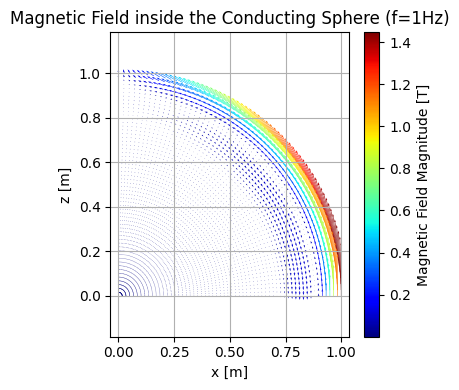

C:\Users\kamea\AppData\Local\Temp\ipykernel_24488\2690396823.py:114: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, Jphi, cmap='coolwarm')


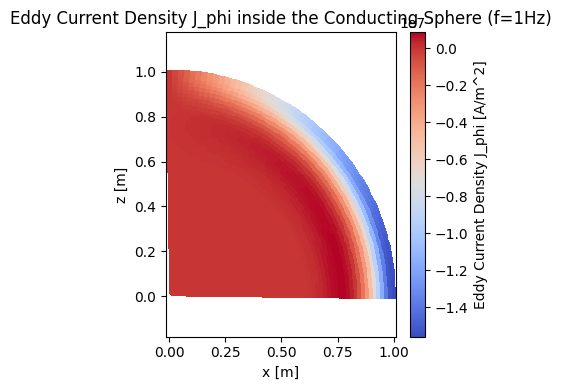

In [1]:
import numpy as np
from scipy.special import spherical_jn, sph_harm
import matplotlib.pyplot as plt

# 定数
MU_0 = 4 * np.pi * 1e-7  # 真空の透磁率 [H/m]

# 導体球と外部磁場のパラメータ
a = 1.0             # 導体球の半径 [m]
sigma = 5e7         # 導電率 [S/m] (銅に近い値)
mu = MU_0           # 透磁率 [H/m]
B0 = 1.0            # 外部磁場の振幅 [T]
f = 1              # 周波数 [Hz]
omega = 2 * np.pi * f  # 角周波数 [rad/s]

# 複素波数
k = np.sqrt(-1j * omega * mu * sigma)

# ---- 解析解の関数 ----
def bessel_factor(z):
    """
    導体球内部の磁場と外部磁場の境界条件から導かれる係数
    """
    # 球ベッセル関数とその微分
    #j1_ka, j1_ka_prime = spherical_jn(1, z, derivative=True)
    #return 3 * spherical_jn(1, z) / (z * j1_ka_prime + j1_ka)
    # 球ベッセル関数
    j1_ka = spherical_jn(1, z)
    j0_ka=spherical_jn(0, z)
    # 球ベッセル関数の導関数
    j1_ka_prime = spherical_jn(1, z, derivative=True)

    #return 3./2. * j1_ka / (z * j1_ka_prime + j1_ka)
    #return 3./2. * z / (z * j1_ka_prime + 2*j1_ka)
    return 3./2.  / (j0_ka)
    
def get_magnetic_field(r, theta, t):
    """
    導体球内部の磁場を計算する
    B = B_r * e_r + B_theta * e_theta
    """
    k_r = k * r
    
    # 磁場の振幅と位相を計算
    B_in_coeff = bessel_factor(k * a)
    j1=spherical_jn(1, k_r)
    j1d=spherical_jn(1, k_r, derivative=True)
    B_r_complex = B0 * B_in_coeff * (2 * j1 / k_r) * np.cos(theta)
    B_theta_complex = -B0 * B_in_coeff * ( j1/k_r +  j1d ) * np.sin(theta)
    
    # 時間依存性を加えて実部を取る
    B_r = np.real(B_r_complex * np.exp(1j * omega * t))
    B_theta = np.real(B_theta_complex * np.exp(1j * omega * t))
    
    return B_r, B_theta

def get_eddy_current(r, theta, t):
    """
    渦電流密度を計算する
    J_phi = (1/mu) * (1/r) * d(r * B_theta)/dr - (1/mu) * (1/r) * dB_r/d_theta
    """
    # 磁場の偏微分を近似で計算
    delta = 1e-6
    r_plus = r + delta
    
    # B_r の theta 微分
    B_r_theta_plus, _ = get_magnetic_field(r, theta + delta, t)
    B_r_theta_minus, _ = get_magnetic_field(r, theta - delta, t)
    dB_r_dtheta = (B_r_theta_plus - B_r_theta_minus) / (2 * delta)

    # B_theta の r 微分
    _, B_theta_r_plus = get_magnetic_field(r_plus, theta, t)
    _, B_theta_r_minus = get_magnetic_field(r - delta, theta, t)
    dB_theta_dr = (B_theta_r_plus - B_theta_r_minus) / (2 * delta)

    J_phi = (1 / mu) * (dB_theta_dr + B_theta_r_minus / r) - (1 / mu) * (1 / r) * dB_r_dtheta
    
    return J_phi

# ---- 計算と可視化 ----
# グリッドの作成
n_grid=60
r_grid = np.linspace(0, a, n_grid)
theta_grid = np.linspace(0, np.pi/2, n_grid)
R, THETA = np.meshgrid(r_grid, theta_grid)
X = R * np.sin(THETA)
Y = R * np.cos(THETA)
TIME=0
#TIME = -1./f/4  # t=0でのスナップショット

# 磁場ベクトルの計算
Br, Btheta = get_magnetic_field(R, THETA, TIME)

# 渦電流密度の計算
Jphi = get_eddy_current(R, THETA, TIME)

# -----------------------------------------------------------
# 磁場ベクトルのプロット
plt.figure(figsize=(4, 4))
plt.quiver(X, Y, Br * np.sin(THETA) + Btheta * np.cos(THETA), Br * np.cos(THETA) - Btheta * np.sin(THETA),
           np.sqrt(Br**2 + Btheta**2), cmap='jet')
plt.colorbar(label='Magnetic Field Magnitude [T]')
plt.title(f'Magnetic Field inside the Conducting Sphere (f={f}Hz)')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.axis('equal')
plt.grid(True)
plt.tight_layout()
plt.show()

# 渦電流密度のプロット (色で表現)
plt.figure(figsize=(4, 4))
plt.pcolormesh(X, Y, Jphi, cmap='coolwarm')
plt.colorbar(label='Eddy Current Density J_phi [A/m^2]')
plt.title(f'Eddy Current Density J_phi inside the Conducting Sphere (f={f}Hz)')
plt.xlabel('x [m]')
plt.ylabel('z [m]')
plt.axis('equal')
plt.tight_layout()
plt.show()